In [3]:
import os
import pandas as pd

folder_path = 'E:/İndirilenler/data/data/opensky_era5'
all_files = [f for f in os.listdir(folder_path) if f.endswith('.parquet')]

dfs = []  # List to store individual DataFrames

for file in all_files:
    file_path = os.path.join(folder_path, file)
    dfs.append(pd.read_parquet(file_path))

# Combine all individual DataFrames into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)
data = combined_df

## Exploratory Data Analysis 

Begin by calculating some basic descriptive statistics for the relevant columns in the dataset. This will give a better understanding of the distribution and central tendencies of the data.

In [4]:
combined_df.head()

,timestamp,flight_id,icao24,latitude,longitude,altitude,geoaltitude,groundspeed,track,track_unwrapped,vertical_rate,callsign,u_component_of_wind,v_component_of_wind,temperature,specific_humidity,longitude_360
0,2022-04-14 10:44:30+00:00,A7MED_040,06a0a3,51.220496,3.646622,37000.0,37400.0,437.0,293.749494,293.749494,0.0,A7MED,7.037550,-16.015054,216.671343,0.000017,NaN
1,2022-04-14 10:44:45+00:00,A7MED_040,06a0a3,51.227060,3.646622,37000.0,37400.0,437.0,293.749494,293.749494,0.0,A7MED,7.054751,-16.045876,216.673689,0.000017,NaN
2,2022-04-14 10:45:00+00:00,A7MED_040,06a0a3,51.238745,3.602142,37000.0,37400.0,438.0,291.291155,291.291155,0.0,A7MED,7.031101,-16.166471,216.627322,0.000017,NaN
3,2022-04-14 10:45:15+00:00,A7MED_040,06a0a3,51.248611,3.555933,37000.0,37400.0,438.0,287.400841,287.400841,0.0,A7MED,6.999383,-16.280800,216.577196,0.000018,NaN
4,2022-04-14 10:45:30+00:00,A7MED_040,06a0a3,51.257505,3.509445,37000.0,37400.0,439.0,286.949224,286.949224,0.0,A7MED,6.961761,-16.392197,216.524592,0.000018,NaN


In [3]:
descriptive_stats = combined_df[['temperature', 'altitude', 'groundspeed', 'specific_humidity', 'u_component_of_wind', 'v_component_of_wind']].describe()

print(descriptive_stats)

        temperature       altitude   groundspeed  specific_humidity  \
count  20447.000000   72585.000000  71918.000000       20447.000000   
mean     225.434318   34094.068958    435.102070           0.000185   
std       11.788606    5792.440973     65.558944           0.000298   
min      204.608868   20025.000000     36.000000           0.000003   
25%      216.586755   31300.000000    410.000000           0.000028   
50%      222.113828   35000.000000    442.000000           0.000087   
75%      231.426980   37300.000000    471.000000           0.000189   
max      261.964727  122900.000000    612.000000           0.003132   

       u_component_of_wind  v_component_of_wind  
count         20447.000000         20447.000000  
mean             18.215504            -8.386713  
std              17.326351            12.348040  
min              -6.424638           -39.639572  
25%               6.717362           -18.595968  
50%              11.290594            -9.591167  
75%       

# Remarks:
# 1.Temperature: 
1- The temperatures (in Kelvin) at which flights operate range from approximately 204.61 K to 261.96 K, with an average of around 225.43 K.
2- Half of the data falls between 216.59 K and 231.43 K (25th to 75th percentile).
# 2.Altitude:
1-The flights have altitudes ranging from 20,025 feet to an unusually high value of 122,900 feet (which might be an outlier or data error). The average altitude is around 34,094 feet.
# 3.Groundspeed:
1-Aircraft ground speeds vary from 36 to 612 units (possibly knots), with an average speed of 435 units.
# 4.Specific Humidty:
1-The specific humidity has a low average value of 0.000185 (likely kg/kg). It varies from very low values to a maximum of 0.003132.
# 5.Wind Components:
1-The average u-component of the wind is 18.22 (possibly m/s), with a wide range from -6.42 to 74.38.
2-The v-component has an average of -8.39, suggesting a predominant wind direction, and ranges from -39.64 to 18.65.
    

## Data Visualization

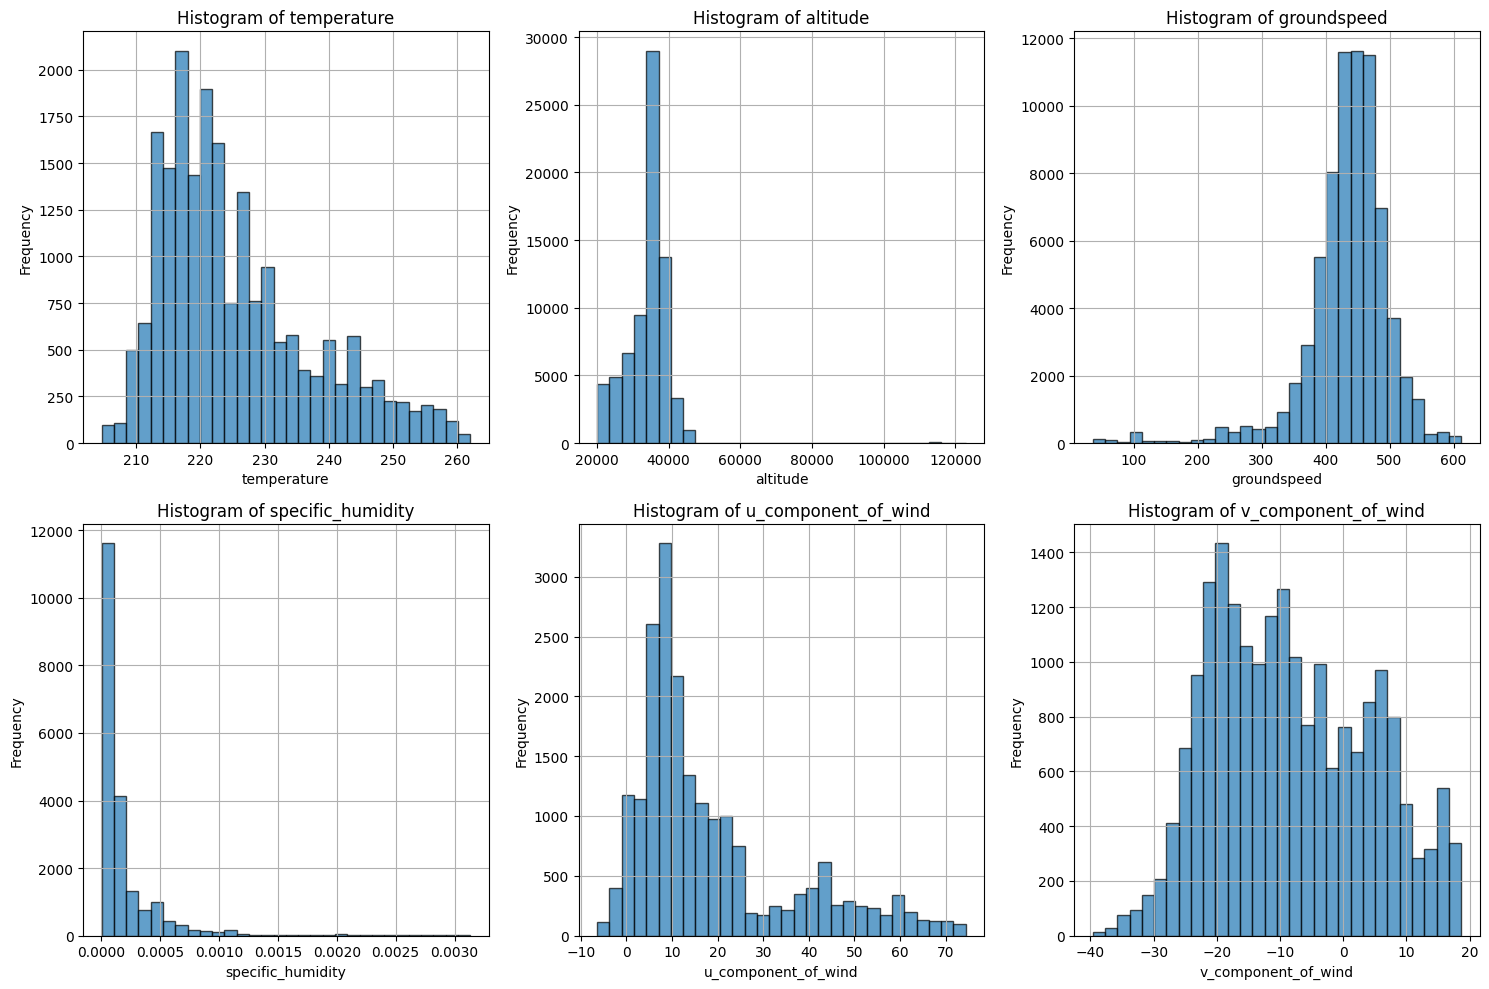

In [4]:
import matplotlib.pyplot as plt

columns_to_plot = ['temperature', 'altitude', 'groundspeed', 'specific_humidity', 'u_component_of_wind', 'v_component_of_wind']
plt.figure(figsize=(15, 10))

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(2, 3, i)
    combined_df[col].hist(bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

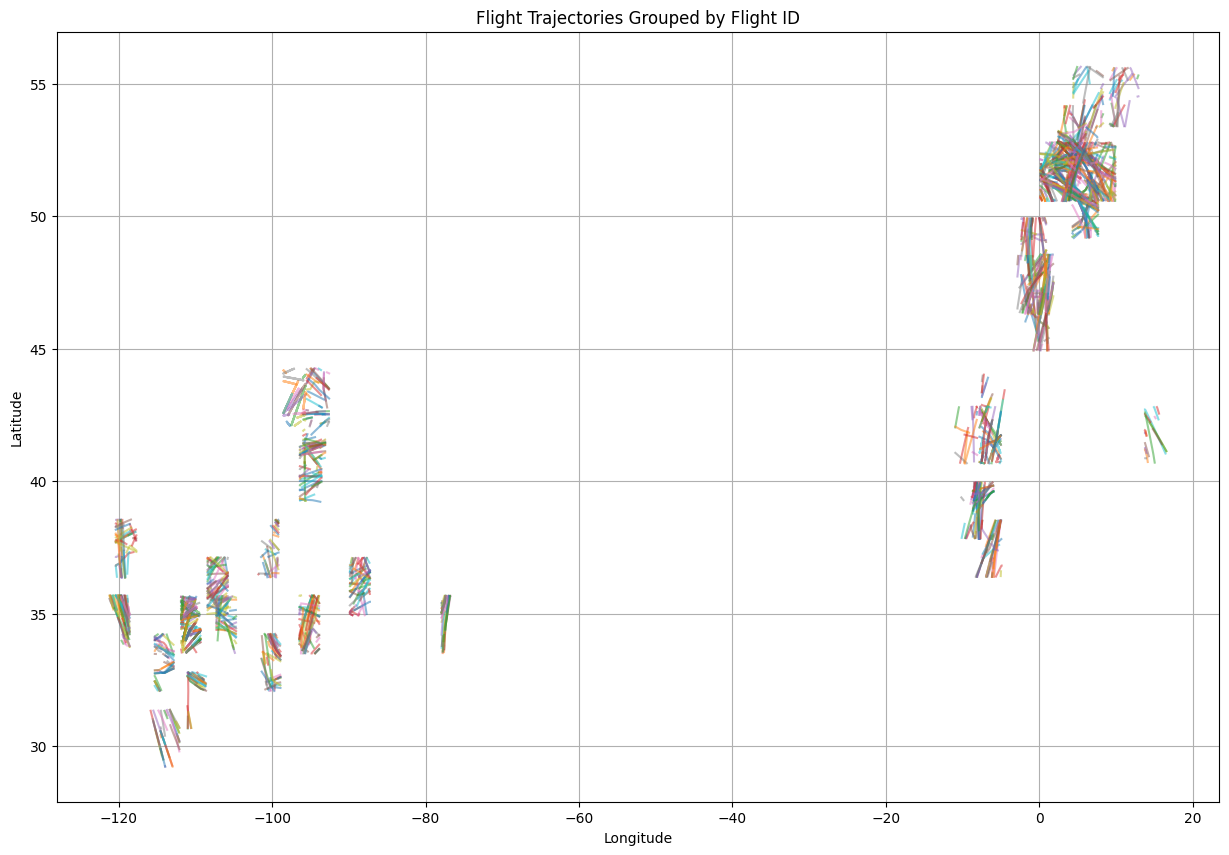

In [5]:
plt.figure(figsize=(15, 10))


for flight_id, group in combined_df.groupby('flight_id'):
    plt.plot(group['longitude'], group['latitude'], label=flight_id, alpha=0.5)

plt.title('Flight Trajectories Grouped by Flight ID')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

# Uncomment the line below if you want a legend, but it might be crowded with many flight_ids
# plt.legend(loc='upper right')

plt.show()


## Feature Derivation

Might be helpful: Overall Relative Wind Speed and Wind Direction, Flight Direction

In [6]:
def calculate_bearing(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlon = lon2 - lon1

    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(dlon))
    initial_bearing = np.arctan2(x, y)

    initial_bearing = np.degrees(initial_bearing)
   
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing
def calculate_bearing_for_group(group):
    group['bearing'] = calculate_bearing(group['latitude'].shift(), 
                                         group['longitude'].shift(),
                                         group['latitude'], 
                                         group['longitude'])
    return group

In [7]:
import numpy as np
data['wind_speed'] = np.sqrt(data['u_component_of_wind']**2 + data['v_component_of_wind']**2)
data['wind_direction'] = np.arctan2(data['v_component_of_wind'], data['u_component_of_wind']) * (180/np.pi)
data = data.groupby('flight_id').apply(calculate_bearing_for_group)

data.head(10)

C:\Users\90539\AppData\Local\Temp\ipykernel_15392\3335804030.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.groupby('flight_id').apply(calculate_bearing_for_group)


,timestamp,flight_id,icao24,latitude,longitude,altitude,geoaltitude,groundspeed,track,track_unwrapped,vertical_rate,callsign,u_component_of_wind,v_component_of_wind,temperature,specific_humidity,longitude_360,wind_speed,wind_direction,bearing
0,2022-04-14 10:44:30+00:00,A7MED_040,06a0a3,51.220496,3.646622,37000.0,37400.0,437.0,293.749494,293.749494,0.0,A7MED,7.037550,-16.015054,216.671343,0.000017,NaN,17.493115,-66.277708,NaN
1,2022-04-14 10:44:45+00:00,A7MED_040,06a0a3,51.227060,3.646622,37000.0,37400.0,437.0,293.749494,293.749494,0.0,A7MED,7.054751,-16.045876,216.673689,0.000017,NaN,17.528253,-66.266764,0.000000
2,2022-04-14 10:45:00+00:00,A7MED_040,06a0a3,51.238745,3.602142,37000.0,37400.0,438.0,291.291155,291.291155,0.0,A7MED,7.031101,-16.166471,216.627322,0.000017,NaN,17.629270,-66.494876,292.777319
3,2022-04-14 10:45:15+00:00,A7MED_040,06a0a3,51.248611,3.555933,37000.0,37400.0,438.0,287.400841,287.400841,0.0,A7MED,6.999383,-16.280800,216.577196,0.000018,NaN,17.721620,-66.736338,288.851764
4,2022-04-14 10:45:30+00:00,A7MED_040,06a0a3,51.257505,3.509445,37000.0,37400.0,439.0,286.949224,286.949224,0.0,A7MED,6.961761,-16.392197,216.524592,0.000018,NaN,17.809274,-66.989083,287.015090
5,2022-04-14 10:45:45+00:00,A7MED_040,06a0a3,51.266397,3.463135,37000.0,37400.0,439.0,287.073966,287.073966,-64.0,A7MED,6.933336,-16.467960,216.473363,0.000018,NaN,17.867984,-67.167948,287.075238
6,2022-04-14 10:46:00+00:00,A7MED_040,06a0a3,51.275381,3.416824,36975.0,37375.0,440.0,287.198541,287.198541,0.0,A7MED,6.811999,-16.638381,216.413911,0.000018,NaN,17.978850,-67.735082,287.246482
7,2022-04-14 10:26:15+00:00,AAL239_3930,aac337,51.230988,0.178379,36000.0,36575.0,435.0,289.476575,289.476575,0.0,AAL239,6.881962,-23.653675,214.064328,0.000026,NaN,24.634483,-73.777812,NaN
8,2022-04-14 10:26:30+00:00,AAL239_3930,aac337,51.230988,0.178379,36000.0,36575.0,434.0,290.648782,290.648782,256.0,AAL239,6.878989,-23.650216,214.065849,0.000026,NaN,24.630331,-73.782204,0.000000
9,2022-04-14 10:32:00+00:00,AAL48_3949,ab79ca,50.687943,0.122833,30725.0,31625.0,487.0,133.254225,133.254225,-1024.0,AAL48,5.313075,-20.215854,225.368851,0.000109,NaN,20.902380,-75.274691,NaN


## Preprocessing

1-Handling Missing Values (Bearing is not very useful predicting contrails.) This cleaned data might be used for visualization later on

In [8]:

data_sample_cleaned = data.dropna(subset=['bearing'])

original_shape = data.shape[0]
cleaned_shape = data_sample_cleaned.shape[0]
dropped_rows = original_shape - cleaned_shape

original_shape, cleaned_shape, dropped_rows


(72585, 70399, 2186)

In [9]:
features_to_scale = ['temperature', 'altitude', 'groundspeed', 'specific_humidity', 
                     'u_component_of_wind', 'v_component_of_wind', 'wind_speed']

nan_counts = data[features_to_scale].isnull().sum()

nan_counts



temperature            52138
altitude                   0
groundspeed              667
specific_humidity      52138
u_component_of_wind    52138
v_component_of_wind    52138
wind_speed             52138
dtype: int64

In [6]:
combined_df.query("temperature != temperature").sort_values("timestamp")

,timestamp,flight_id,icao24,latitude,longitude,altitude,geoaltitude,groundspeed,track,track_unwrapped,vertical_rate,callsign,u_component_of_wind,v_component_of_wind,temperature,specific_humidity,longitude_360
66204,2021-02-07 17:50:30+00:00,AAL1939_951,ad7b17,33.195923,-113.069147,39000.0,39625.0,481.0,100.304846,100.304846,0.0,AAL1939,NaN,NaN,NaN,NaN,246.930853
66419,2021-02-07 17:50:30+00:00,N1245_079,a06595,33.487771,-112.864230,38000.0,38600.0,295.0,315.686967,315.686967,0.0,N1245,NaN,NaN,NaN,NaN,247.135770
66582,2021-02-07 17:50:30+00:00,N731QS_630,a9d031,33.784495,-115.196972,21200.0,21975.0,399.0,259.168694,259.168694,-1152.0,N731QS,NaN,NaN,NaN,NaN,244.803028
66891,2021-02-07 17:50:30+00:00,SWQ1814_635,a9e5ff,33.994632,-114.644737,26000.0,26625.0,380.0,281.369000,281.369000,0.0,SWQ1814,NaN,NaN,NaN,NaN,245.355263
66928,2021-02-07 17:50:30+00:00,UAL1875_679,aa56da,32.273712,-114.945007,38000.0,38700.0,408.0,302.481968,302.481968,0.0,UAL1875,NaN,NaN,NaN,NaN,245.054993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51667,2023-05-04 10:39:30+00:00,RYR4CY_4297,4ca27b,52.232346,3.462830,37000.0,37750.0,458.0,78.665530,78.665530,0.0,RYR4CY,NaN,NaN,NaN,NaN,3.462830
49621,2023-05-04 10:39:30+00:00,AMX025_5490,aa9800,52.298786,2.215236,26325.0,27050.0,495.0,77.282926,77.282926,-1152.0,AMX025,NaN,NaN,NaN,NaN,2.215236
50197,2023-05-04 10:39:30+00:00,DAL23_5535,ab649a,51.175232,3.930730,32000.0,32775.0,449.0,289.645243,289.645243,0.0,DAL23,NaN,NaN,NaN,NaN,3.930730
50085,2023-05-04 10:39:30+00:00,CFE56D_1092,406c43,51.038524,2.344894,30850.0,31675.0,412.0,119.675892,119.675892,576.0,CFE56D,NaN,NaN,NaN,NaN,2.344894


Handling missing temperatures: Linear Regression to predict temperature by using altitude

Calculation of Saturation Ratio
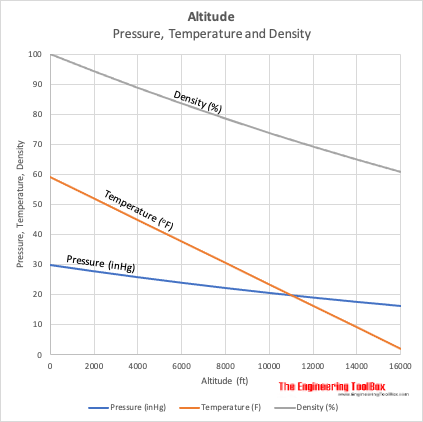

In [10]:
from sklearn.linear_model import LinearRegression


data_with_temp = data.dropna(subset=['temperature'])
data_missing_temp = data[data['temperature'].isnull()]


regressor = LinearRegression()
regressor.fit(data_with_temp[['altitude']], data_with_temp['temperature'])


predicted_temps = regressor.predict(data_missing_temp[['altitude']])
data_missing_temp['temperature'] = predicted_temps

data_interpolated = pd.concat([data_with_temp, data_missing_temp], axis=0).sort_index()


remaining_nans = data_interpolated['temperature'].isnull().sum()

remaining_nans


C:\Users\90539\AppData\Local\Temp\ipykernel_15392\2796193629.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_missing_temp['temperature'] = predicted_temps


0

See the flights with all NaN cells 

In [11]:
columns_to_interpolate = ['groundspeed', 'specific_humidity', 'u_component_of_wind', 
                          'v_component_of_wind', 'wind_speed']

non_nan_counts = data_interpolated.groupby('flight_id')[columns_to_interpolate].count()
flights_all_nan = non_nan_counts[non_nan_counts.sum(axis=1) == 0]
flights_all_nan

,groundspeed,specific_humidity,u_component_of_wind,v_component_of_wind,wind_speed
flight_id,,,,,
OH15_1610,0,0,0,0,0
OH48_1532,0,0,0,0,0
ULC22_3270,0,0,0,0,0


Conclusion: Each flight have at least one datapoint in the columns we are interested in

Let's interpolate the missing values. Use backward or fordward fill if there is still missing values after the interpolation.

In [12]:


for col in columns_to_interpolate:
    data_interpolated[col] = data_interpolated.groupby('flight_id')[col].transform(lambda group: group.interpolate(method='linear'))

    data_interpolated[col].fillna(method='bfill', inplace=True)
    data_interpolated[col].fillna(method='ffill', inplace=True)


remaining_nans = data_interpolated[columns_to_interpolate].isnull().sum()

remaining_nans


groundspeed            0
specific_humidity      0
u_component_of_wind    0
v_component_of_wind    0
wind_speed             0
dtype: int64

# Saturation Ratio Calculation

In [13]:
# 1. Calculate p_ws (Saturation Vapor Pressure over Water)
data_interpolated['p_ws'] = 6.112 * np.exp((17.67 * (data['temperature'] - 273.15)) / (data['temperature'] - 273.15 + 243.5))


In [14]:
# 2. Compute Absolute Humidity from Specific Humidity
# Assuming specific_humidity is in kg/kg
M_H2O = 18.01528  # g/mol
altitude = data['altitude'] * 0.3048  # Convert altitude from feet to meters
T0 = 288.15  # Standard sea level temperature in Kelvin
P0 = 101325  # Standard sea level pressure in Pascal
L = 0.0065  # Temperature lapse rate in K/m
R = 287.05  # Gas constant for dry air in J/(kg*K)
g0 = 9.8  # Gravitational acceleration in m/s^2

In [15]:
# Calculate pressure at given altitude using ISA model (simplified barometric formula)
data_interpolated['pressure'] = P0 * (1 - L * altitude / T0) ** (g0 / (R * L))

# Calculate air density
data_interpolated['air_density'] = data_interpolated['pressure'] / (R * data_interpolated['temperature'])

# Calculate absolute humidity
data_interpolated['absolute_humidity'] = (data_interpolated['specific_humidity'] * data_interpolated['air_density']) / M_H2O

In [16]:
# 3. Calculate p_w (Partial Pressure of Water Vapor)
data_interpolated['p_w'] = (data_interpolated['specific_humidity'] * data_interpolated['pressure']) / (0.622 + data_interpolated['specific_humidity'])

In [17]:
data_interpolated.head()

,timestamp,flight_id,icao24,latitude,longitude,altitude,geoaltitude,groundspeed,track,track_unwrapped,...,specific_humidity,longitude_360,wind_speed,wind_direction,bearing,p_ws,pressure,air_density,absolute_humidity,p_w
0,2022-04-14 10:44:30+00:00,A7MED_040,06a0a3,51.220496,3.646622,37000.0,37400.0,437.0,293.749494,293.749494,...,0.000017,NaN,17.493115,-66.277708,NaN,0.029425,21681.07631,0.348596,3.339181e-07,0.601503
1,2022-04-14 10:44:45+00:00,A7MED_040,06a0a3,51.227060,3.646622,37000.0,37400.0,437.0,293.749494,293.749494,...,0.000017,NaN,17.528253,-66.266764,0.000000,0.029433,21681.07631,0.348592,3.341982e-07,0.602014
2,2022-04-14 10:45:00+00:00,A7MED_040,06a0a3,51.238745,3.602142,37000.0,37400.0,438.0,291.291155,291.291155,...,0.000017,NaN,17.629270,-66.494876,292.777319,0.029266,21681.07631,0.348666,3.370003e-07,0.606931
3,2022-04-14 10:45:15+00:00,A7MED_040,06a0a3,51.248611,3.555933,37000.0,37400.0,438.0,287.400841,287.400841,...,0.000018,NaN,17.721620,-66.736338,288.851764,0.029086,21681.07631,0.348747,3.398317e-07,0.611889
4,2022-04-14 10:45:30+00:00,A7MED_040,06a0a3,51.257505,3.509445,37000.0,37400.0,439.0,286.949224,286.949224,...,0.000018,NaN,17.809274,-66.989083,287.015090,0.028898,21681.07631,0.348832,3.426051e-07,0.616733


In [18]:
# Calculate p_wi (Saturation Vapor Pressure with respect to Ice)
data_interpolated['p_wi'] = np.exp(9.550426 - 5723.265 / data_interpolated['temperature'] + 
                      3.53068 * np.log(data_interpolated['temperature']) - 
                      0.00728332 * data_interpolated['temperature'])


# Compute the Saturation Ratio (Si)
data_interpolated['Si'] = data_interpolated['p_w'] / data_interpolated['p_wi']

# Assess Contrail Formation
data_interpolated['contrail_formation'] = data_interpolated['Si'] > 1

In [19]:
data_interpolated.head()

,timestamp,flight_id,icao24,latitude,longitude,altitude,geoaltitude,groundspeed,track,track_unwrapped,...,wind_direction,bearing,p_ws,pressure,air_density,absolute_humidity,p_w,p_wi,Si,contrail_formation
0,2022-04-14 10:44:30+00:00,A7MED_040,06a0a3,51.220496,3.646622,37000.0,37400.0,437.0,293.749494,293.749494,...,-66.277708,NaN,0.029425,21681.07631,0.348596,3.339181e-07,0.601503,1.728380,0.348015,False
1,2022-04-14 10:44:45+00:00,A7MED_040,06a0a3,51.227060,3.646622,37000.0,37400.0,437.0,293.749494,293.749494,...,-66.266764,0.000000,0.029433,21681.07631,0.348592,3.341982e-07,0.602014,1.728911,0.348204,False
2,2022-04-14 10:45:00+00:00,A7MED_040,06a0a3,51.238745,3.602142,37000.0,37400.0,438.0,291.291155,291.291155,...,-66.494876,292.777319,0.029266,21681.07631,0.348666,3.370003e-07,0.606931,1.718446,0.353186,False
3,2022-04-14 10:45:15+00:00,A7MED_040,06a0a3,51.248611,3.555933,37000.0,37400.0,438.0,287.400841,287.400841,...,-66.736338,288.851764,0.029086,21681.07631,0.348747,3.398317e-07,0.611889,1.707198,0.358417,False
4,2022-04-14 10:45:30+00:00,A7MED_040,06a0a3,51.257505,3.509445,37000.0,37400.0,439.0,286.949224,286.949224,...,-66.989083,287.015090,0.028898,21681.07631,0.348832,3.426051e-07,0.616733,1.695468,0.363754,False


In [20]:
number_of_contrails = data_interpolated['contrail_formation'].sum()
print(number_of_contrails)

28789


Feature Scaling: Relevant Features- Temperature, Altitude, Groundspeed, Specific Humidity, Wind speed

In [21]:
from sklearn.preprocessing import StandardScaler

features_to_scale = ['temperature', 'altitude', 'groundspeed', 'specific_humidity']
scaler = StandardScaler()
data_interpolated[features_to_scale] = scaler.fit_transform(data_interpolated[features_to_scale])
print(data_interpolated[features_to_scale].head())

   temperature  altitude  groundspeed  specific_humidity
0    -0.693325   0.50168     0.029558          -0.707485
1    -0.693120   0.50168     0.029558          -0.707426
2    -0.697177   0.50168     0.044864          -0.706860
3    -0.701564   0.50168     0.044864          -0.706289
4    -0.706168   0.50168     0.060170          -0.705731


Data Split

In [22]:
from sklearn.model_selection import train_test_split
X = X = data_interpolated[features_to_scale] # contrail_formation already dropped
y = data_interpolated['contrail_formation']
# 0.85 Test, 0.075 Training, 0.075 Validation -- Can be changed to CV later on
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.15, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train.shape, X_val.shape, X_test.shape


((61697, 4), (5444, 4), (5444, 4))

# Logistic Regression for Beginning

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


logreg = LogisticRegression(max_iter=1000, random_state=42)

logreg.fit(X_train, y_train)


y_val_pred = logreg.predict(X_val)


accuracy = accuracy_score(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)

accuracy, report


(0.8139235855988244,
 '              precision    recall  f1-score   support\n\n       False       0.80      0.92      0.86      3259\n        True       0.84      0.66      0.74      2185\n\n    accuracy                           0.81      5444\n   macro avg       0.82      0.79      0.80      5444\nweighted avg       0.82      0.81      0.81      5444\n')

# Neural Networks

Data preparation

In [29]:
import torch
from torch.utils.data import DataLoader, TensorDataset

#Convert to tensor
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Model Architecture (Start with Perceptron):

Number of Input Neurons = Number of Features

Hidden Layer 1 = 128 (Arbitrary w/ ReLU activation function)

Hidden Layer 2 = 64 (Arbitrary w/ ReLU activation function)

Output Layer = 1 Neuron

Loss Function = Binary Cross-Entropy since this is a binary classification?

Optimizer Algorithm = Adam?

In [30]:

import torch.nn as nn
import torch.nn.functional as F

class ContrailNet(nn.Module):
    def __init__(self, input_dim):
        super(ContrailNet, self).__init__()
        

        self.fc1 = nn.Linear(input_dim, 128)
        
        self.fc2 = nn.Linear(128, 64)
     
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

input_dim = X_train.shape[1]
model = ContrailNet(input_dim)




In [31]:
import torch
criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} => Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}")

print("Training complete!")


Epoch 1/20 => Train loss: 0.1458, Validation loss: 0.0742
Epoch 2/20 => Train loss: 0.0568, Validation loss: 0.0510
Epoch 3/20 => Train loss: 0.0545, Validation loss: 0.0340
Epoch 4/20 => Train loss: 0.0399, Validation loss: 0.0343
Epoch 5/20 => Train loss: 0.0337, Validation loss: 0.0251
Epoch 6/20 => Train loss: 0.0330, Validation loss: 0.0463
Epoch 7/20 => Train loss: 0.0311, Validation loss: 0.0811
Epoch 8/20 => Train loss: 0.0387, Validation loss: 0.0245
Epoch 9/20 => Train loss: 0.0273, Validation loss: 0.0203
Epoch 10/20 => Train loss: 0.0262, Validation loss: 0.0217
Epoch 11/20 => Train loss: 0.0255, Validation loss: 0.0385
Epoch 12/20 => Train loss: 0.0267, Validation loss: 0.0264
Epoch 13/20 => Train loss: 0.0272, Validation loss: 0.0177
Epoch 14/20 => Train loss: 0.0277, Validation loss: 0.0180
Epoch 15/20 => Train loss: 0.0242, Validation loss: 0.0190
Epoch 16/20 => Train loss: 0.0249, Validation loss: 0.0154
Epoch 17/20 => Train loss: 0.0228, Validation loss: 0.0292
Epoch 